In [114]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
from datetime import datetime
import re
from sklearn.metrics import accuracy_score


In [115]:
# read the data (2012)
df = pd.read_csv('data/BPI_Challenge_2012-training.csv')

df_test = pd.read_csv('data/BPI_Challenge_2012-test.csv')

# read the data (road traffic fines)
# df = pd.read_csv('data/Road_Traffic_Fine_Management_Process-training.csv')

# read the data (2017)
# df = pd.read_csv('data/BPI Challenge 2017-training.csv')

# read the data (2018)
# df = pd.read_csv('data/BPI Challenge 2018-training.csv')

df.head(10)

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,A_SUBMITTED,COMPLETE,01-10-2011 00:38:44.546
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,A_PARTLYSUBMITTED,COMPLETE,01-10-2011 00:38:44.880
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,A_PREACCEPTED,COMPLETE,01-10-2011 00:39:37.906
3,3,173688,2011-10-01T00:38:44.546+02:00,20000,W_Completeren aanvraag,SCHEDULE,01-10-2011 00:39:38.875
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,A_SUBMITTED,COMPLETE,01-10-2011 08:08:58.256
5,4294967297,173691,2011-10-01T08:08:58.256+02:00,5000,A_PARTLYSUBMITTED,COMPLETE,01-10-2011 08:09:02.195
6,4294967298,173691,2011-10-01T08:08:58.256+02:00,5000,A_PREACCEPTED,COMPLETE,01-10-2011 08:09:56.648
7,4294967299,173691,2011-10-01T08:08:58.256+02:00,5000,W_Completeren aanvraag,SCHEDULE,01-10-2011 08:09:59.578
8,8589934592,173694,2011-10-01T08:10:30.287+02:00,7000,A_SUBMITTED,COMPLETE,01-10-2011 08:10:30.287
9,8589934593,173694,2011-10-01T08:10:30.287+02:00,7000,A_PARTLYSUBMITTED,COMPLETE,01-10-2011 08:10:30.591


In [116]:
# Defining database-specific variables
case_column = "case concept:name"
registration_time_column = "case REG_DATE"
event_column = "event concept:name"
timestamp_column = "event time:timestamp"
position_column = "Position"
baseline_next_event_column = "Baseline Prediction for Next Activity"
position_next_event_column = "Position Prediction for Next Activity"
pos_event_next_event_column = "Position&Event Prediction for Next Activity"
baseline_next_timestamp_column = "Baseline Prediction for Next Timestamp"
position_next_timestamp_column = "Position Prediction for Next Timestamp"
pos_event_next_timestamp_column = "Position&Event Prediction for Next Timestamp"
time_since_registration_column = "Time Since Registration"
day_of_week_column = "day_of_week"
month_of_year_column = "month_of_year"
offer_sent = 'O_SENT' # the name a of a sent offer state within event_column
timeformat_registration = "%Y-%m-%dT%H:%M:%S" # new time format
timeformat_timestamp = "%d-%m-%Y %H:%M:%S.%f"
predicted_event_shift_column = 'Predicted event from baseline'
predicted_time_shift_column = 'Predicted time from baseline'


In [117]:
df[registration_time_column]= [re.sub('\..*|\+.*','',a,flags=re.DOTALL) for a in df[registration_time_column]]
df[registration_time_column] = [datetime.strptime(date, timeformat_registration) for date in df[registration_time_column]]
df[timestamp_column] = [datetime.strptime(date, timeformat_timestamp) for date in df[timestamp_column]]
df = df.sort_values(by=[case_column, timestamp_column])  # sort values by user and time of event
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214377 entries, 0 to 199657
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   eventID                     214377 non-null  int64         
 1   case concept:name           214377 non-null  int64         
 2   case REG_DATE               214377 non-null  datetime64[ns]
 3   case AMOUNT_REQ             214377 non-null  int64         
 4   event concept:name          214377 non-null  object        
 5   event lifecycle:transition  214377 non-null  object        
 6   event time:timestamp        214377 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 13.1+ MB


In [118]:
# adding the day of the week and month of the year columns

df[time_since_registration_column] = df[timestamp_column] - df[registration_time_column] # Adding time since registration 
df[day_of_week_column] = df[timestamp_column].dt.day_name()
df[month_of_year_column] = df[timestamp_column].dt.month_name()

In [119]:
# add column offer sent (binary)
df_offersentevents = df[df[event_column] == offer_sent].copy()
df_firsteventofcase = df_offersentevents[df_offersentevents[case_column].shift(periods=1) != df_offersentevents[case_column]]
dict_timestamp_offer_sent = dict(zip(df_firsteventofcase[case_column],df_firsteventofcase[timestamp_column]))

df[offer_sent] = [(True if ((case in dict_timestamp_offer_sent) and (dict_timestamp_offer_sent[case] <= time)) else False) for case,time in zip(df[case_column],df[timestamp_column])]
#df.head(40)

In [120]:
# We create a dictionary length_process that stores the total length of a trace indexed by the case number
# We fill in the Position column that shows which position is a certain event in the trace (the first event is 1)

df[position_column] = df.groupby([case_column]).cumcount()+1
length_process = df.groupby([case_column]).size().to_dict()

#length_process
#df[df[case_column] == 173688]

In [121]:
# here you can see different statistics about the process length
print(f'Mean: {statistics.mean(length_process.values())}')
#print(f'Mode: {statistics.mode(length_process.values())}') # This line can cause a critical error if there exist multiple modes
print(f'Median: {statistics.median(length_process.values())}')
print(f'Max: {max(length_process.values())}') # this is df[df['case concept:name'] == 185548]
print(f'Min: {min(length_process.values())}')

Mean: 20.477313974591652
Median: 11
Max: 175
Min: 3


In [122]:
# the dictionary prediction_step stores the most common event for each position (if there are multiple modes we pick the first event that is encountered)
# for example, the most common activity to occur in position 2 is prediction_step[1]; prediction for position n+1 is prediction_step[n]
# If there is no next prediction after position n then prediction_step[n] == "-"

prediction_step = {i: df[event_column][df[position_column] == i+1].mode()[0] for i in range(1, max(length_process.values()))}
prediction_step[max(length_process.values())] = "-"

#prediction_step

In [123]:
# We add the baseline predicted next event as a new column to the dataframe
df[position_next_event_column] = [prediction_step[x] for x in df[position_column]]

#df[df[case_column] == 173688]

In [124]:
# We create a dictionary to store the average time duration until the next event
# For example the average time duration between position n and n+1 is average_time_per_pos[n]
# The dataframe must be sorted on case-number and timestamp for this calculation to work!
# if there exists no event in the dataset of n+1 then average_time_per_pos[n] == pd.Timedelta(0)

# Code Explanation: We subtract the timestamps and then shift the results up so the difference from n to n+1 is on row n.
# Only if the position numbers are consecutive (so both events are in the same trace) should include the row in the mean() calculation.
shifted_deltatimes = df[timestamp_column].diff().shift(periods=-1)[(df[position_column].diff()==1).shift(periods=-1, fill_value=False)]

# The mean() function will return NaT if the input is empty, we replace this with pd.Timedelta(0)
def replacenat(timedelt):
    if (pd.isna(timedelt)):
        return pd.Timedelta(0)
    return timedelt

# We select only the rows of a certain position i and then calculate the mean() on those timedeltas

average_time_per_pos = {i: replacenat(shifted_deltatimes[df[position_column] == i].mean()) for i in range(1, max(length_process.values()) + 1)}

#average_time_per_pos

In [125]:
# We add the baseline predicted time duration until next event to the dataframe 
df[position_next_timestamp_column] = [x + average_time_per_pos[y] for x,y in zip(df[timestamp_column], df[position_column])]

df[df[case_column] == 185548] # Note that the events of pos 173 and 174 happen at the exact same timestamp!

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,Time Since Registration,day_of_week,month_of_year,O_SENT,Position,Position Prediction for Next Activity,Position Prediction for Next Timestamp
64935,16333760626688,185548,2011-11-15 13:42:45,20000,A_SUBMITTED,COMPLETE,2011-11-15 13:42:45.593,0 days 00:00:00.593000,Tuesday,November,False,1,A_PARTLYSUBMITTED,2011-11-15 13:42:46.175640462
64936,16333760626689,185548,2011-11-15 13:42:45,20000,A_PARTLYSUBMITTED,COMPLETE,2011-11-15 13:42:45.889,0 days 00:00:00.889000,Tuesday,November,False,2,W_Afhandelen leads,2011-11-15 13:43:20.991779539
64938,16333760626690,185548,2011-11-15 13:42:45,20000,A_PREACCEPTED,COMPLETE,2011-11-15 13:43:31.963,0 days 00:00:46.963000,Tuesday,November,False,3,W_Afhandelen leads,2011-11-15 16:34:47.624069032
64939,16333760626691,185548,2011-11-15 13:42:45,20000,W_Completeren aanvraag,SCHEDULE,2011-11-15 13:43:32.557,0 days 00:00:47.557000,Tuesday,November,False,4,W_Completeren aanvraag,2011-11-15 16:59:25.467088057
64989,16333760626692,185548,2011-11-15 13:42:45,20000,W_Completeren aanvraag,START,2011-11-15 13:59:33.696,0 days 00:16:48.696000,Tuesday,November,False,5,W_Completeren aanvraag,2011-11-15 14:17:23.742873248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165456,16333760626858,185548,2011-11-15 13:42:45,20000,W_Nabellen incomplete dossiers,COMPLETE,2012-01-17 10:54:42.893,62 days 21:11:57.893000,Tuesday,January,True,171,W_Nabellen incomplete dossiers,2012-01-17 11:20:51.763000000
165539,16333760626859,185548,2011-11-15 13:42:45,20000,W_Nabellen incomplete dossiers,START,2012-01-17 11:20:51.763,62 days 21:38:06.763000,Tuesday,January,True,172,O_CANCELLED,2012-01-17 11:25:56.714000000
165555,16333760626861,185548,2011-11-15 13:42:45,20000,O_CANCELLED,COMPLETE,2012-01-17 11:25:56.714,62 days 21:43:11.714000,Tuesday,January,True,173,A_CANCELLED,2012-01-17 11:25:56.714000000
165556,16333760626860,185548,2011-11-15 13:42:45,20000,A_CANCELLED,COMPLETE,2012-01-17 11:25:56.714,62 days 21:43:11.714000,Tuesday,January,True,174,W_Nabellen incomplete dossiers,2012-01-17 11:26:00.120000000


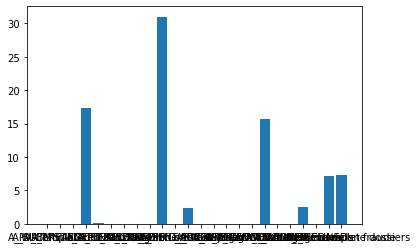

In [126]:
# list of unique events in the data
unique_events = df[event_column].unique()

# dictionary to store the average time for each event
time_per_event = {event: replacenat(shifted_deltatimes[df[event_column] == event].mean()) for event in unique_events}

hours_per_event = {event: (time_per_event[event].total_seconds()/(60*60)) for event in unique_events}

plt.bar(hours_per_event.keys(), hours_per_event.values())
plt.show()


In [127]:
def getNumberOfActiveEvents(timestamp):
    assert isinstance(timestamp, pd.Timestamp)
    df_previousevents = df[df[timestamp_column] <= timestamp].copy()
    df_lastrowofcase = df_previousevents[(df_previousevents[position_column].diff()!=1).shift(periods=-1, fill_value=True)]
    return {event: len(df_lastrowofcase[df_lastrowofcase[event_column] == event]) for event in unique_events}

getNumberOfActiveEvents(pd.Timestamp("2012-01-17 11:20:51.763"))

{'A_SUBMITTED': 0,
 'A_PARTLYSUBMITTED': 0,
 'A_PREACCEPTED': 0,
 'W_Completeren aanvraag': 1545,
 'A_ACCEPTED': 0,
 'A_FINALIZED': 0,
 'O_SELECTED': 0,
 'O_CREATED': 0,
 'O_SENT': 0,
 'W_Nabellen offertes': 1067,
 'O_SENT_BACK': 0,
 'W_Valideren aanvraag': 1618,
 'O_ACCEPTED': 0,
 'A_REGISTERED': 0,
 'A_APPROVED': 0,
 'A_ACTIVATED': 1,
 'O_CANCELLED': 141,
 'W_Wijzigen contractgegevens': 2,
 'A_DECLINED': 2323,
 'A_CANCELLED': 359,
 'W_Afhandelen leads': 1622,
 'O_DECLINED': 0,
 'W_Nabellen incomplete dossiers': 249,
 'W_Beoordelen fraude': 44}

In [128]:
# apply the average time to the dataframe
df[baseline_next_timestamp_column] = [(time + time_per_event[event]) for event,time in zip(df[event_column], df[timestamp_column])]
df[df[case_column] == 185548]


,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,Time Since Registration,day_of_week,month_of_year,O_SENT,Position,Position Prediction for Next Activity,Position Prediction for Next Timestamp,Baseline Prediction for Next Timestamp
64935,16333760626688,185548,2011-11-15 13:42:45,20000,A_SUBMITTED,COMPLETE,2011-11-15 13:42:45.593,0 days 00:00:00.593000,Tuesday,November,False,1,A_PARTLYSUBMITTED,2011-11-15 13:42:46.175640462,2011-11-15 13:42:46.175640462
64936,16333760626689,185548,2011-11-15 13:42:45,20000,A_PARTLYSUBMITTED,COMPLETE,2011-11-15 13:42:45.889,0 days 00:00:00.889000,Tuesday,November,False,2,W_Afhandelen leads,2011-11-15 13:43:20.991779539,2011-11-15 13:43:20.991779539
64938,16333760626690,185548,2011-11-15 13:42:45,20000,A_PREACCEPTED,COMPLETE,2011-11-15 13:43:31.963,0 days 00:00:46.963000,Tuesday,November,False,3,W_Afhandelen leads,2011-11-15 16:34:47.624069032,2011-11-15 13:43:32.465771753
64939,16333760626691,185548,2011-11-15 13:42:45,20000,W_Completeren aanvraag,SCHEDULE,2011-11-15 13:43:32.557,0 days 00:00:47.557000,Tuesday,November,False,4,W_Completeren aanvraag,2011-11-15 16:59:25.467088057,2011-11-16 07:02:01.714379243
64989,16333760626692,185548,2011-11-15 13:42:45,20000,W_Completeren aanvraag,START,2011-11-15 13:59:33.696,0 days 00:16:48.696000,Tuesday,November,False,5,W_Completeren aanvraag,2011-11-15 14:17:23.742873248,2011-11-16 07:18:02.853379243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165456,16333760626858,185548,2011-11-15 13:42:45,20000,W_Nabellen incomplete dossiers,COMPLETE,2012-01-17 10:54:42.893,62 days 21:11:57.893000,Tuesday,January,True,171,W_Nabellen incomplete dossiers,2012-01-17 11:20:51.763000000,2012-01-17 18:08:57.358645946
165539,16333760626859,185548,2011-11-15 13:42:45,20000,W_Nabellen incomplete dossiers,START,2012-01-17 11:20:51.763,62 days 21:38:06.763000,Tuesday,January,True,172,O_CANCELLED,2012-01-17 11:25:56.714000000,2012-01-17 18:35:06.228645946
165555,16333760626861,185548,2011-11-15 13:42:45,20000,O_CANCELLED,COMPLETE,2012-01-17 11:25:56.714,62 days 21:43:11.714000,Tuesday,January,True,173,A_CANCELLED,2012-01-17 11:25:56.714000000,2012-01-17 11:25:58.074857292
165556,16333760626860,185548,2011-11-15 13:42:45,20000,A_CANCELLED,COMPLETE,2012-01-17 11:25:56.714,62 days 21:43:11.714000,Tuesday,January,True,174,W_Nabellen incomplete dossiers,2012-01-17 11:26:00.120000000,2012-01-17 11:28:58.061432222


In [129]:
# We create a list containing all unique combinations of position numbers and events that exist in the data

unique_pos_event = list({(pos,event) for event,pos in zip(df[event_column],df[position_column])})

len(unique_pos_event)

1754

In [130]:
# We create dictionary that takes into account the most recent event AND the position in the trace to give the most likely next event

# The mode() function can return an empty series if the input is empty, then we should output "-"
def get_first_mode(srs):
    if (len(srs)>0):
        return srs[0]
    return "-"

pos_event_prediction = {(pos,event): get_first_mode(df[event_column][(df[event_column].shift() == event) & (df[position_column] == pos+1)].mode()) for pos,event in unique_pos_event}

#pos_event_prediction#[("A_PARTLYSUBMITTED", 2)]

In [131]:
# We add the predicted next event as a new column to the dataframe
df[pos_event_next_event_column] = [pos_event_prediction[(pos, event)] for pos,event in zip(df[position_column], df[event_column])]
#df[df[case_column] == 185548]

In [132]:
# We calculate the average time-difference between the next event and the current time for every pair of position

pos_event_timedelta = {(pos,event): replacenat(shifted_deltatimes[(df[position_column]==pos)&(df[event_column]==event)].mean()) for pos,event in unique_pos_event}

#pos_event_timedelta

In [133]:
# We add the predicted next timestamp as a new column to the dataframe
df[pos_event_next_timestamp_column] = [time+pos_event_timedelta[(pos,event)] for pos,event,time in zip(df[position_column], df[event_column], df[timestamp_column])]
df[df[case_column] == 185548]

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,Time Since Registration,day_of_week,month_of_year,O_SENT,Position,Position Prediction for Next Activity,Position Prediction for Next Timestamp,Baseline Prediction for Next Timestamp,Position&Event Prediction for Next Activity,Position&Event Prediction for Next Timestamp
64935,16333760626688,185548,2011-11-15 13:42:45,20000,A_SUBMITTED,COMPLETE,2011-11-15 13:42:45.593,0 days 00:00:00.593000,Tuesday,November,False,1,A_PARTLYSUBMITTED,2011-11-15 13:42:46.175640462,2011-11-15 13:42:46.175640462,A_PARTLYSUBMITTED,2011-11-15 13:42:46.175640462
64936,16333760626689,185548,2011-11-15 13:42:45,20000,A_PARTLYSUBMITTED,COMPLETE,2011-11-15 13:42:45.889,0 days 00:00:00.889000,Tuesday,November,False,2,W_Afhandelen leads,2011-11-15 13:43:20.991779539,2011-11-15 13:43:20.991779539,W_Afhandelen leads,2011-11-15 13:43:20.991779539
64938,16333760626690,185548,2011-11-15 13:42:45,20000,A_PREACCEPTED,COMPLETE,2011-11-15 13:43:31.963,0 days 00:00:46.963000,Tuesday,November,False,3,W_Afhandelen leads,2011-11-15 16:34:47.624069032,2011-11-15 13:43:32.465771753,W_Completeren aanvraag,2011-11-15 13:43:32.673225130
64939,16333760626691,185548,2011-11-15 13:42:45,20000,W_Completeren aanvraag,SCHEDULE,2011-11-15 13:43:32.557,0 days 00:00:47.557000,Tuesday,November,False,4,W_Completeren aanvraag,2011-11-15 16:59:25.467088057,2011-11-16 07:02:01.714379243,W_Completeren aanvraag,2011-11-15 20:04:36.891513350
64989,16333760626692,185548,2011-11-15 13:42:45,20000,W_Completeren aanvraag,START,2011-11-15 13:59:33.696,0 days 00:16:48.696000,Tuesday,November,False,5,W_Completeren aanvraag,2011-11-15 14:17:23.742873248,2011-11-16 07:18:02.853379243,W_Completeren aanvraag,2011-11-15 14:11:02.151681413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165456,16333760626858,185548,2011-11-15 13:42:45,20000,W_Nabellen incomplete dossiers,COMPLETE,2012-01-17 10:54:42.893,62 days 21:11:57.893000,Tuesday,January,True,171,W_Nabellen incomplete dossiers,2012-01-17 11:20:51.763000000,2012-01-17 18:08:57.358645946,W_Nabellen incomplete dossiers,2012-01-17 11:20:51.763000000
165539,16333760626859,185548,2011-11-15 13:42:45,20000,W_Nabellen incomplete dossiers,START,2012-01-17 11:20:51.763,62 days 21:38:06.763000,Tuesday,January,True,172,O_CANCELLED,2012-01-17 11:25:56.714000000,2012-01-17 18:35:06.228645946,O_CANCELLED,2012-01-17 11:25:56.714000000
165555,16333760626861,185548,2011-11-15 13:42:45,20000,O_CANCELLED,COMPLETE,2012-01-17 11:25:56.714,62 days 21:43:11.714000,Tuesday,January,True,173,A_CANCELLED,2012-01-17 11:25:56.714000000,2012-01-17 11:25:58.074857292,A_CANCELLED,2012-01-17 11:25:56.714000000
165556,16333760626860,185548,2011-11-15 13:42:45,20000,A_CANCELLED,COMPLETE,2012-01-17 11:25:56.714,62 days 21:43:11.714000,Tuesday,January,True,174,W_Nabellen incomplete dossiers,2012-01-17 11:26:00.120000000,2012-01-17 11:28:58.061432222,W_Nabellen incomplete dossiers,2012-01-17 11:26:00.120000000


In [134]:
df[df['day_of_week']=='Saturday']

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,Time Since Registration,day_of_week,month_of_year,O_SENT,Position,Position Prediction for Next Activity,Position Prediction for Next Timestamp,Baseline Prediction for Next Timestamp,Position&Event Prediction for Next Activity,Position&Event Prediction for Next Timestamp
0,0,173688,2011-10-01 00:38:44,20000,A_SUBMITTED,COMPLETE,2011-10-01 00:38:44.546,0 days 00:00:00.546000,Saturday,October,False,1,A_PARTLYSUBMITTED,2011-10-01 00:38:45.128640462,2011-10-01 00:38:45.128640462,A_PARTLYSUBMITTED,2011-10-01 00:38:45.128640462
1,1,173688,2011-10-01 00:38:44,20000,A_PARTLYSUBMITTED,COMPLETE,2011-10-01 00:38:44.880,0 days 00:00:00.880000,Saturday,October,False,2,W_Afhandelen leads,2011-10-01 00:39:19.982779539,2011-10-01 00:39:19.982779539,W_Afhandelen leads,2011-10-01 00:39:19.982779539
2,2,173688,2011-10-01 00:38:44,20000,A_PREACCEPTED,COMPLETE,2011-10-01 00:39:37.906,0 days 00:00:53.906000,Saturday,October,False,3,W_Afhandelen leads,2011-10-01 03:30:53.567069032,2011-10-01 00:39:38.408771753,W_Completeren aanvraag,2011-10-01 00:39:38.616225130
3,3,173688,2011-10-01 00:38:44,20000,W_Completeren aanvraag,SCHEDULE,2011-10-01 00:39:38.875,0 days 00:00:54.875000,Saturday,October,False,4,W_Completeren aanvraag,2011-10-01 03:55:31.785088057,2011-10-01 17:58:08.032379243,W_Completeren aanvraag,2011-10-01 07:00:43.209513350
89,4,173688,2011-10-01 00:38:44,20000,W_Completeren aanvraag,START,2011-10-01 11:36:46.437,0 days 10:58:02.437000,Saturday,October,False,5,W_Completeren aanvraag,2011-10-01 11:54:36.483873248,2011-10-02 04:55:15.594379243,W_Completeren aanvraag,2011-10-01 11:48:14.892681413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200137,44951127719952,206315,2012-02-03 17:04:58,7000,W_Completeren aanvraag,COMPLETE,2012-02-04 11:26:20.972,0 days 18:21:22.972000,Saturday,February,True,17,W_Nabellen offertes,2012-02-05 00:26:25.599002161,2012-02-05 04:44:50.129379243,W_Completeren aanvraag,2012-02-05 14:13:36.921816952
206367,44951127719953,206315,2012-02-03 17:04:58,7000,W_Nabellen offertes,START,2012-02-11 16:20:10.518,7 days 23:15:12.518000,Saturday,February,True,18,W_Nabellen offertes,2012-02-12 20:18:47.148377228,2012-02-12 23:18:56.213287283,W_Nabellen offertes,2012-02-13 12:37:33.349365143
206369,44951127719955,206315,2012-02-03 17:04:58,7000,O_CANCELLED,COMPLETE,2012-02-11 16:21:43.728,7 days 23:16:45.728000,Saturday,February,True,19,W_Nabellen offertes,2012-02-12 08:18:37.335350157,2012-02-11 16:21:45.088857292,O_SELECTED,2012-02-11 16:21:45.863880000
206370,44951127719954,206315,2012-02-03 17:04:58,7000,A_CANCELLED,COMPLETE,2012-02-11 16:21:43.728,7 days 23:16:45.728000,Saturday,February,True,20,W_Nabellen offertes,2012-02-12 17:34:09.300022482,2012-02-11 16:24:45.075432222,O_CANCELLED,2012-02-11 16:21:44.766433962


In [135]:
# ACCURACY

df_test[position_column] = df_test.groupby([case_column]).cumcount()+1
df_test[baseline_next_event_column] = [prediction_step[x] for x in df_test[position_column]]
df_test[predicted_event_shift_column] = df_test[baseline_next_event_column].shift(1)
accuracy_next_event = accuracy_score(df_test[df_test[position_column] != 1][event_column],df_test[df_test[position_column] != 1][predicted_event_shift_column])
accuracy_next_event



0.3289901559561995

In [136]:
df_test[registration_time_column]= [re.sub('\..*|\+.*','',a,flags=re.DOTALL) for a in df_test[registration_time_column]]
df_test[registration_time_column] = [datetime.strptime(date, timeformat_registration) for date in df_test[registration_time_column]]
df_test[timestamp_column] = [datetime.strptime(date, timeformat_timestamp) for date in df_test[timestamp_column]]
df_test[baseline_next_timestamp_column] = [x + average_time_per_pos[y] for x,y in zip(df_test[timestamp_column], df_test[position_column])]
df_test[predicted_time_shift_column] = df_test[baseline_next_timestamp_column].shift(1)


In [137]:
df_test_time = df_test[df_test[position_column] != 1][[timestamp_column, predicted_time_shift_column]]
# # Mean Absolute Error (MAE)
MAE = np.mean(abs(df_test_time[predicted_time_shift_column] - df_test_time[timestamp_column] ))
print('Mean Absolute Error (MAE): ' + str(MAE))

Mean Absolute Error (MAE): 0 days 11:02:35.095135361
